In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, get_linear_schedule_with_warmup
)

from torch.optim import AdamW
import evaluate
from tqdm.auto import tqdm

2025-11-12 16:41:57.061303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762965717.085294     234 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762965717.092514     234 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
DATA_DIR = Path('data')
PROC_DIR = DATA_DIR / 'processed'
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'distilbert-base-uncased'
NUM_LABELS = 3
LABEL2ID = {'negative': 0, 'neutral': 1, 'positive': 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [ ]:
train_csv = PROC_DIR /'train.csv'
val_csv = PROC_DIR / 'test.csv'

# Data Analyze

In [6]:
df_train = pd.read_csv(train_csv)
print('Train shape:', df_train.shape)
display(df_train.head(3))

df_val = pd.read_csv(val_csv)
print('Validation shape:', df_val.shape)

Train shape: (650000, 2)


,text,label
0,dr. goldberg offers everything i look for in a...,positive
1,"Unfortunately, the frustration of being Dr. Go...",negative
2,Been going to Dr. Goldberg for over 10 years. ...,positive


Validation shape: (50000, 2)


In [ ]:
print('\nClass counts:')
display(df_train['label'].value_counts())
print('\nClass relative:')
display(df_train['label'].value_counts(normalize=True))

df_train['text_len_chars'] = df_train['text'].str.len()
print('\nText length stats:')
display(df_train['text_len_chars'].describe())


Class counts:


label
positive    260000
negative    260000
neutral     130000
Name: count, dtype: int64


Class relative:


label
positive    0.4
negative    0.4
neutral     0.2
Name: proportion, dtype: float64


Text length stats:


count    650000.000000
mean        732.325468
std         663.721184
min           1.000000
25%         287.000000
50%         539.000000
75%         957.000000
max        5637.000000
Name: text_len_chars, dtype: float64

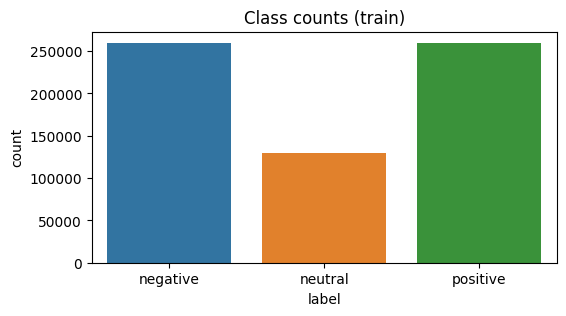

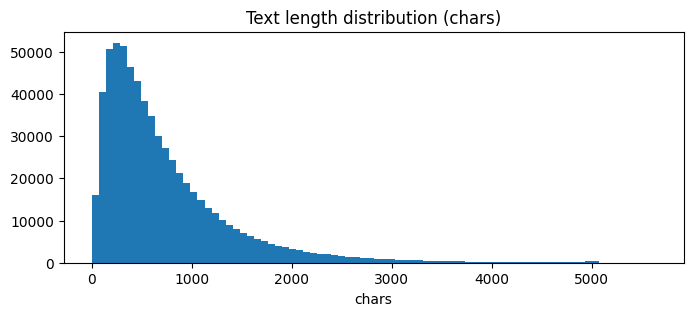

In [8]:
plt.figure(figsize=(6,3))
sns.countplot(data=df_train, x='label', order=['negative','neutral','positive'])
plt.title('Class counts (train)')
plt.show()

plt.figure(figsize=(8,3))
plt.hist(df_train['text_len_chars'], bins=80)
plt.title('Text length distribution (chars)')
plt.xlabel('chars'); plt.show()

In [9]:
for lab in ['negative','neutral','positive']:
    sample = df_train[df_train['label']==lab].sample(3, random_state=42)['text'].tolist()
    print(f"\n--- Examples for {lab} ---")
    for s in sample:
        print('-', s.replace('\n',' ')[:300])


--- Examples for negative ---
- Awful service, awful food.\n\nWas here several weeks ago as part of a large group; I arrived partway through the meal and did not order anything, so can't speak for the food on that occasion (though it looked good), but the service was excellent. We had a male waiter who handled our giant group with
- food is decent but english is the second language. my order has been messed up more than once so i stop going.
- If you enjoy paying tons of money to be treated like dirt and wade in filthy toilet water, while your ears bleed to house music that makes it impossible to talk, then this is the place for you.  It was a little baffling to me that the power tripping boys running the line at the entrance could not mu

--- Examples for neutral ---
- If you go in for theme restaurants,this one is tops. A neat place to take people--if you can,ask to sit inside one of the boats!  Kids love this place.But be forewarned-if you are having a nice lunch or dinner in one o

In [10]:
raw_ds = load_dataset('csv', data_files={'train': str(train_csv), 'validation': str(val_csv)})
print(raw_ds)

def label_to_id(example):
    example['label'] = LABEL2ID[example['label']]
    return example

raw_ds = raw_ds.map(label_to_id)
print('After mapping labels:', raw_ds)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 650000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
After mapping labels: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 650000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


# Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
max_length = 256

def preprocess_fn(examples):
    return tokenizer(
        examples['text'], 
        truncation=True, 
        padding=False,
        max_length=max_length
    )

tokenized = raw_ds.map(preprocess_fn, batched=True, 
                      remove_columns=[c for c in raw_ds['train'].column_names if c not in ['text', 'label']])
print("Tokenized dataset:", tokenized)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 650000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [12]:
tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
print("Dataset format set to torch")

Dataset format set to torch


# Prepare data for training

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='longest', return_tensors="pt")

train_dataloader = DataLoader(tokenized['train'], batch_size=16, shuffle=True,
                              collate_fn=data_collator, num_workers=0)
val_dataloader = DataLoader(tokenized['validation'], batch_size=32, shuffle=False,
                            collate_fn=data_collator, num_workers=0)

print(f"Train size: {len(tokenized['train'])}, batches: {len(train_dataloader)}")
print(f"Val size:   {len(tokenized['validation'])}, batches: {len(val_dataloader)}")

Train size: 650000, batches: 40625
Val size:   50000, batches: 1563


In [14]:
sample_batch = next(iter(train_dataloader))
print('Batch keys:', sample_batch.keys())
print('input_ids shape', sample_batch['input_ids'].shape)
print('labels shape', sample_batch['labels'].shape)

Batch keys: KeysView({'input_ids': tensor([[ 101, 1045, 2034,  ...,    0,    0,    0],
        [ 101, 2065, 2017,  ...,    0,    0,    0],
        [ 101, 2057, 2344,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 8235,  ...,    0,    0,    0],
        [ 101, 1045, 2074,  ...,    0,    0,    0],
        [ 101, 2031, 1045,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([2, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 2])})
input_ids shape torch.Size([16, 256])
labels shape torch.Size([16])


# Model and optimizer

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,
    label2id=LABEL2ID
).to(device)

print(f"Model downloaded on {device}")
print(f"Model params {sum(p.numel() for p in model.parameters()):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model downloaded on cuda
Model params 66,955,779


In [16]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
total_steps = len(train_dataloader) * 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [17]:
metric_f1 = evaluate.load('f1')
metric_acc = evaluate.load('accuracy')
metric_precision = evaluate.load('precision')
metric_recall = evaluate.load('recall')

In [18]:
epochs = 3

# Training loop

In [19]:
use_amp = True if (device == 'cuda' and torch.cuda.is_available()) else False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

/tmp/ipykernel_234/3727884837.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [20]:
def train_epoch(model, dataloader, optimizer, scheduler, device, scaler=None):
    model.train()
    losses = []
    all_preds = []
    all_labels = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='train')
    for step, batch in pbar:
        # move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop('labels')  # collator returns 'labels'
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(**batch, labels=labels)
                loss = outputs.loss
            scaler.scale(loss).backward()
            # gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

        if (step + 1) % 50 == 0:
            pbar.set_postfix({'loss': np.mean(losses[-50:])})

    # compute metrics for epoch
    res = {}
    res['train_loss'] = float(np.mean(losses))
    res.update(metric_acc.compute(predictions=all_preds, references=all_labels))
    # f1 (macro)
    f1 = metric_f1.compute(predictions=all_preds, references=all_labels, average='macro')['f1']
    res['f1_macro'] = f1
    return res

In [21]:
def eval_epoch(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='eval'):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop('labels')
            outputs = model(**batch, labels=labels)
            loss = outputs.loss
            losses.append(loss.item())
            logits = outputs.logits.detach().cpu().numpy()
            preds = np.argmax(logits, axis=-1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

    res = {}
    res['eval_loss'] = float(np.mean(losses)) if len(losses) else None
    res.update(metric_acc.compute(predictions=all_preds, references=all_labels))
    res['f1_macro'] = metric_f1.compute(predictions=all_preds, references=all_labels, average='macro')['f1']
    res['precision_macro'] = metric_precision.compute(predictions=all_preds, references=all_labels, average='macro')['precision']
    res['recall_macro'] = metric_recall.compute(predictions=all_preds, references=all_labels, average='macro')['recall']
    return res, all_preds, all_labels

In [ ]:
best_f1 = -1.0
history = []

for epoch in range(1, epochs + 1):
    print(f"===== Epoch {epoch}/{epochs} =====")
    train_res = train_epoch(model, train_dataloader, optimizer, scheduler, device, scaler if use_amp else None)
    print("Train:", train_res)

    eval_res, preds, labels = eval_epoch(model, val_dataloader, device)
    print("Eval:", eval_res)

    history.append({'epoch': epoch, **train_res, **{'eval_' + k: v for k, v in eval_res.items()}})

    if eval_res['f1_macro'] > best_f1:
        best_f1 = eval_res['f1_macro']
        out_dir = MODELS_DIR / f'best_model_epoch{epoch}_f1{best_f1:.4f}'
        model.save_pretrained(out_dir)
        tokenizer.save_pretrained(out_dir)
        print("Saved best model to", out_dir)

print("\n=== Final classification report (validation) ===")
print(classification_report(labels, preds, target_names=['negative','neutral','positive']))

pd.DataFrame(history).to_csv(MODELS_DIR/'training_history.csv', index=False)
print("History saved to", MODELS_DIR/'training_history.csv')

===== Epoch 1/3 =====


train:   0%|          | 0/40625 [00:00<?, ?it/s]

/tmp/ipykernel_234/148505565.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train: {'train_loss': 0.4611995205897551, 'accuracy': 0.8079015384615384, 'f1_macro': 0.7574010667058383}


eval:   0%|          | 0/1563 [00:00<?, ?it/s]

Eval: {'eval_loss': 0.4067804587293495, 'accuracy': 0.82978, 'f1_macro': 0.7909284733529343, 'precision_macro': 0.7922850302287986, 'recall_macro': 0.7898333333333333}
Saved best model to models/best_model_epoch1_f10.7909
===== Epoch 2/3 =====


train:   0%|          | 0/40625 [00:00<?, ?it/s]

/tmp/ipykernel_234/148505565.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train: {'train_loss': 0.37449839484086406, 'accuracy': 0.8461784615384615, 'f1_macro': 0.8062506794078054}


eval:   0%|          | 0/1563 [00:00<?, ?it/s]

Eval: {'eval_loss': 0.41609514357137206, 'accuracy': 0.83562, 'f1_macro': 0.793866403371892, 'precision_macro': 0.799513261541145, 'recall_macro': 0.7909833333333333}
Saved best model to models/best_model_epoch2_f10.7939
===== Epoch 3/3 =====


train:   0%|          | 0/40625 [00:00<?, ?it/s]

/tmp/ipykernel_234/148505565.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train: {'train_loss': 0.30060915075173744, 'accuracy': 0.8808692307692307, 'f1_macro': 0.8500530463468997}


eval:   0%|          | 0/1563 [00:00<?, ?it/s]

Eval: {'eval_loss': 0.416559304527209, 'accuracy': 0.84034, 'f1_macro': 0.8012187076522909, 'precision_macro': 0.8035312561238624, 'recall_macro': 0.7994333333333333}
Saved best model to models/best_model_epoch3_f10.8012

=== Final classification report (validation) ===
              precision    recall  f1-score   support

    negative       0.89      0.90      0.89     20000
     neutral       0.64      0.59      0.61     10000
    positive       0.89      0.91      0.90     20000

    accuracy                           0.84     50000
   macro avg       0.80      0.80      0.80     50000
weighted avg       0.84      0.84      0.84     50000

History saved to models/training_history.csv
